# A Long-Term Memory Agent

This tutorial implements an agent with long-term memory capabilities using LangGraph. The agent can store, retrieve, and use memories to enhance its interactions with users.

Inspired by papers like [MemGPT](https://memgpt.ai/) and distilled from our own works on long-term memory, the graph extracts memories from chat interactions and persists them to a database. "Memory" in this tutorial will be represented in two ways:

* a piece of text information that is generated by the agent
* structured information about entities extracted by the agent in the shape of `(subject, predicate, object)` knowledge triples.

This information can later be read or queried semantically to provide personalized context when your bot is responding to a particular user.

The KEY idea is that by saving memories, the agent persists information about users that is SHARED across multiple conversations (threads), which is different from memory of a single conversation that is already enabled by LangGraph's [persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/).

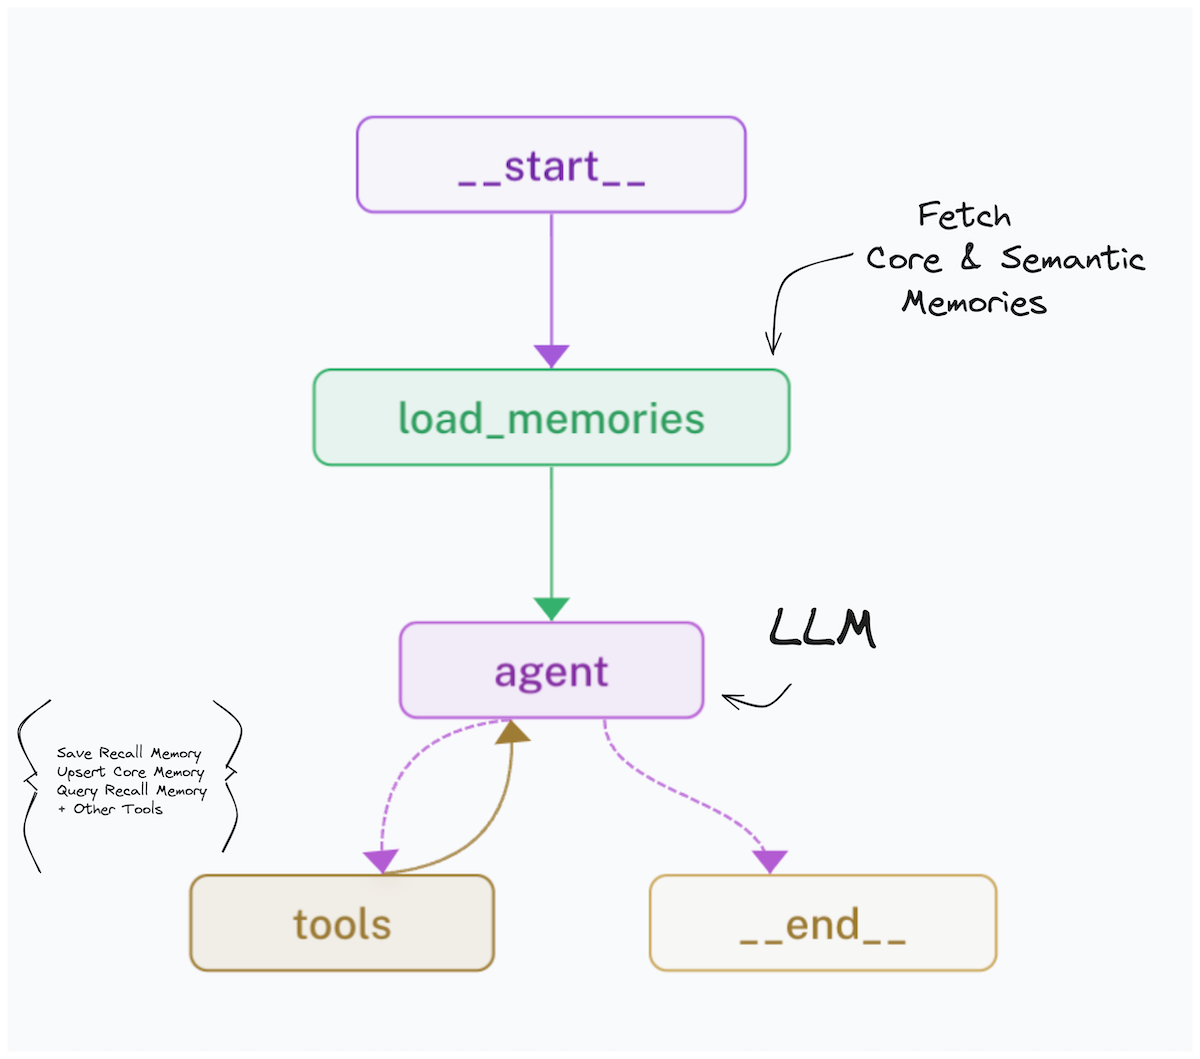

In this tutorial we'll also distinguish between two types of memories:
* **core** - these are the fundamental memories about the user that will be always available to the model. We will be using LangGraph's `Store` API to save and load these.
* **recall** - these are contextual memories that will be looked up depending on the conversation context. We will be using a vector store to save and retrieve these.

You can also check out a full implementation of this agent in [this repo](https://github.com/langchain-ai/lang-memgpt).

## Install dependencies

In [1]:
%pip install -U --quiet langgraph langchain-openai langchain-community tiktoken

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

OPENAI_API_KEY:  ········
TAVILY_API_KEY:  ········


In [3]:
from typing import List, Optional, Literal
import json

import tiktoken
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_core.messages import get_buffer_string

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langgraph.prebuilt import ToolNode

## Define for memories

First, let's define two stores where we will be storing our memories.

* core memories will be stored as strings and will be always included when generating model response
* recall memories will be stored as embeddings and later looked up based on the conversation context. We will be using an in-memory vectorstore.

In [4]:
core_memory_store = InMemoryStore()
recall_vector_store = InMemoryVectorStore(OpenAIEmbeddings())

### Define tools

Next, let's define our memory tools. We will need a tool to store the memories and another tool to search them to find the most relevant memory.

In [5]:
import uuid


def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")

    return user_id


@tool
def save_core_memory(memory: str, index: Optional[int] = None, config: RunnableConfig = None) -> str:
    """Store a core memory in the database.

    Args:
        memory (str): The memory to store.
        index (Optional[int]): The index at which to store the memory.

    Returns:
        str: Stored memory.
    """
    user_id = get_user_id(config)
    memories = core_memory_store.search(("memories", user_id))
    if index is not None:
        if index < 0 or index >= len(memories):
            return "Error: Index out of bounds."
        memory_key = memories[index].key
    else:
        memory_key = str(uuid.uuid4())
    
    core_memory_store.put(("memories", user_id), memory_key, {"memory": memory})
    return memory


@tool
def save_recall_memory(memory: str, config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    user_id = get_user_id(config)
    document = Document(
        page_content=memory, id=str(uuid.uuid4()), metadata={"user_id": user_id}
    )
    recall_vector_store.add_documents([document])
    return memory


@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    """Search for relevant memories."""
    user_id = get_user_id(config)

    def _filter_function(doc: Document) -> bool:
        return doc.metadata.get("user_id") == user_id

    documents = recall_vector_store.similarity_search(
        query, k=3, filter=_filter_function
    )
    return [document.page_content for document in documents]

Additionally, let's give our agent ability to search the web using [Tavily](https://tavily.com/).

In [6]:
search = TavilySearchResults(max_results=1)
tools = [save_core_memory, save_recall_memory, search_recall_memories, search]

### Define state, nodes and edges

Our graph state will contain just two channels -- `messages` for keeping track of the chat history and `recall_memories` -- contextual memories that will be pulled in before calling the agent and passed to the agent's system prompt.

In [7]:
class State(MessagesState):
    # add memories that will be retrieved based on the conversation context
    recall_memories: List[str]

In [8]:
# Define the prompt template for the agent
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant with advanced long-term memory"
            " capabilities. Powered by a stateless LLM, you must rely on"
            " external memory to store information between conversations."
            " Utilize the available memory tools to store and retrieve"
            " important details that will help you better attend to the user's"
            " needs and understand their context.\n\n"
            "Memory Usage Guidelines:\n"
            "1. Actively use memory tools (save_core_memory, save_recall_memory)"
            " to build a comprehensive understanding of the user.\n"
            "2. Make informed suppositions and extrapolations based on stored"
            " memories.\n"
            "3. Regularly reflect on past interactions to identify patterns and"
            " preferences.\n"
            "4. Update your mental model of the user with each new piece of"
            " information.\n"
            "5. Cross-reference new information with existing memories for"
            " consistency.\n"
            "6. Prioritize storing emotional context and personal values"
            " alongside facts.\n"
            "7. Use memory to anticipate needs and tailor responses to the"
            " user's style.\n"
            "8. Recognize and acknowledge changes in the user's situation or"
            " perspectives over time.\n"
            "9. Leverage memories to provide personalized examples and"
            " analogies.\n"
            "10. Recall past challenges or successes to inform current"
            " problem-solving.\n\n"
            "## Core Memories\n"
            "Core memories are fundamental to understanding the user and are"
            " always available:\n{core_memories}\n\n"
            "## Recall Memories\n"
            "Recall memories are contextually retrieved based on the current"
            " conversation:\n{recall_memories}\n\n"
            "## Instructions\n"
            "Engage with the user naturally, as a trusted colleague or friend."
            " There's no need to explicitly mention your memory capabilities."
            " Instead, seamlessly incorporate your understanding of the user"
            " into your responses. Be attentive to subtle cues and underlying"
            " emotions. Adapt your communication style to match the user's"
            " preferences and current emotional state. Use tools to persist"
            " information you want to retain in the next conversation. If you"
            " do call tools, all text preceding the tool call is an internal"
            " message. Respond AFTER calling the tool, once you have"
            " confirmation that the tool completed successfully."
            " REMEMBER: Use save_core_memories for key information like name, location, etc.\n\n"
        ),
        ("placeholder", "{messages}"),
    ]
)

In [14]:
model = ChatOpenAI(model_name="gpt-4o")
model_with_tools = model.bind_tools(tools, parallel_tool_calls=False)

tokenizer = tiktoken.encoding_for_model("gpt-4o")


def agent(state: State, config: RunnableConfig, *, store: BaseStore) -> State:
    """Process the current state and generate a response using the LLM.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.
        store (BaseStore): the Store object the graph was compiled with

    Returns:
        schemas.State: The updated state with the agent's response.
    """
    bound = prompt | model_with_tools
    # we can directly load core memories from the store parameter passed to the `agent` node
    user_id = get_user_id(config)
    core_memories = [item.value["memory"] for item in core_memory_store.search(("memories", user_id))]
    core_str = (
        "<core_memory>\n" + "\n".join(core_memories) + "\n</core_memory>"
    )
    recall_str = (
        "<recall_memory>\n" + "\n".join(state["recall_memories"]) + "\n</recall_memory>"
    )
    prediction = bound.invoke(
        {
            "messages": state["messages"],
            "recall_memories": recall_str,
            "core_memories": core_str
        }
    )
    return {
        "messages": [prediction],
    }


def load_memories(state: State, config: RunnableConfig) -> State:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """
    convo_str = get_buffer_string(state["messages"])
    convo_str = tokenizer.decode(tokenizer.encode(convo_str)[:2048])
    recall_memories = search_recall_memories.invoke(convo_str, config)
    return {
        "recall_memories": recall_memories,
    }


def route_tools(state: State):
    """Determine whether to use tools or end the conversation based on the last message.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        Literal["tools", "__end__"]: The next step in the graph.
    """
    msg = state["messages"][-1]
    if msg.tool_calls:
        return "tools"

    return END

## Build the graph

Our agent graph is going to be very similar to simple [ReAct agent](https://langchain-ai.github.io/langgraph/reference/prebuilt/#create_react_agent). The only important modification is adding a node to load memories BEFORE calling the agent for the first time.

In [15]:
# Create the graph and add nodes
builder = StateGraph(State)
builder.add_node(load_memories)
builder.add_node(agent)
builder.add_node("tools", ToolNode(tools))

# Add edges to the graph
builder.add_edge(START, "load_memories")
builder.add_edge("load_memories", "agent")
builder.add_conditional_edges("agent", route_tools, path_map=["tools", END])
builder.add_edge("tools", "agent")

# Compile the graph
memory = MemorySaver()
# Note that we're compiling the graph with our core memory store object
graph = builder.compile(checkpointer=memory, store=core_memory_store)

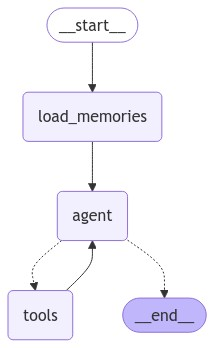

In [16]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

## Run the agent!

Let's run the agent for the first time and tell it some information about the user!

In [17]:
def pretty_print_stream_chunk(chunk):
    for node, updates in chunk.items():
        print(f"Update from node: {node}")
        if "messages" in updates:
            updates["messages"][-1].pretty_print()
        else:
            print(updates)

        print("\n")

In [18]:
# NOTE: we're specifying `user_id` to save memories for a given user
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

for chunk in graph.stream({"messages": [("user", "my name is John")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_core_memory (call_MftjuCuEsPlCzxbJ9dItXUjb)
 Call ID: call_MftjuCuEsPlCzxbJ9dItXUjb
  Args:
    memory: The user's name is John.


Update from node: tools
================================= Tool Message =================================
Name: save_core_memory

The user's name is John.


Update from node: agent
================================== Ai Message ==================================

Hi John! How can I assist you today?




You can see that the agent saved the memory about user's name. Let's add some more information about the user!

In [19]:
for chunk in graph.stream({"messages": [("user", "i love pizza")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_Vk56Vz47zqYYjJLmjYBJIiur)
 Call ID: call_Vk56Vz47zqYYjJLmjYBJIiur
  Args:
    memory: John loves pizza.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

John loves pizza.


Update from node: agent
================================== Ai Message ==================================

Pizza is amazing! Do you have a favorite topping or style?




In [20]:
for chunk in graph.stream(
    {"messages": [("user", "yes -- pepperoni!")]},
    config={"configurable": {"user_id": "1", "thread_id": "1"}},
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['John loves pizza.']}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_gTo3Oik1DsSFL0udsC4lMgFe)
 Call ID: call_gTo3Oik1DsSFL0udsC4lMgFe
  Args:
    memory: John's favorite pizza topping is pepperoni.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

John's favorite pizza topping is pepperoni.


Update from node: agent
================================== Ai Message ==================================

Pepperoni is a classic choice! Do you have a favorite place to get your pepperoni pizza from?




In [21]:
for chunk in graph.stream(
    {"messages": [("user", "i also just moved to new york")]},
    config={"configurable": {"user_id": "1", "thread_id": "1"}},
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['John loves pizza.', "John's favorite pizza topping is pepperoni."]}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_core_memory (call_3pFUPG3nZl1CCD78zExWpDAP)
 Call ID: call_3pFUPG3nZl1CCD78zExWpDAP
  Args:
    memory: John has just moved to New York.


Update from node: tools
================================= Tool Message =================================
Name: save_core_memory

John has just moved to New York.


Update from node: agent
================================== Ai Message ==================================

Welcome to New York, John! It's a fantastic place for pizza lovers. Have you had a chance to explore any of the local pizzerias yet?




Now we can use the saved information about our user on a different thread. Let's try it out:

In [22]:
config = {"configurable": {"user_id": "1", "thread_id": "2"}}

for chunk in graph.stream(
    {"messages": [("user", "where should i go for dinner?")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['John loves pizza.', "John's favorite pizza topping is pepperoni."]}


Update from node: agent
================================== Ai Message ==================================

New York has an incredible dining scene with a variety of options. Since you love pizza, I’d suggest trying out one of the city's renowned pizzerias. Here are a few recommendations:

1. **Lucali** in Brooklyn – Known for its delicious thin-crust pizza.
2. **Joe's Pizza** in Greenwich Village – A classic spot for a quintessential New York slice.
3. **Prince Street Pizza** in SoHo – Famous for their pepperoni square slices.

If you’re in the mood for something else, let me know your preferences, and I can suggest other types of cuisine!




Notice how the agent is loading the most relevant memories before answering, and in our case suggests the dinner recommendations based on both the food preferences as well as location.

Finally, let's use the search tool together with the rest of the conversation context and memory to find location of a pizzeria:

In [23]:
for chunk in graph.stream(
    {"messages": [("user", "what's the address for joe's in greenwich village?")]},
    config=config,
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['John loves pizza.', "John's favorite pizza topping is pepperoni."]}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_f3dO9WXEDDECRPpYMcIIryzo)
 Call ID: call_f3dO9WXEDDECRPpYMcIIryzo
  Args:
    query: Joe's Pizza Greenwich Village address


Update from node: tools
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.joespizzanyc.com/locations-1-1", "content": "Joe's Pizza Greenwich Village (Original Location) 7 Carmine Street New York, NY 10014 ... Joe's Pizza Michigan 1107 S University Ave Ann Arbor, MI 48104 (734) 213-5625. ORDER JOE'S MICHIGAN Joe's Pizza Miami 234 NW 25th Street Miami, FL 33127 (786) 230-1441 ..."}]


Update from node: agent
================================== Ai Message ==================================

Joe's Pizza in Green

If you were to pass a different user ID, the agent's response will not be personalized as we haven't saved any information about the other user:

## Adding structured memories

So far we've represented memories as strings, e.g., `"John loves pizza"`. This is a natural representation when persisting memories to a vector store. If your use-case would benefit from other persistence backends -- such as a graph database -- we can update our application to generate memories with additional structure.

Below, we update the `save_recall_memory` tool to accept a list of "knowledge triples", or 3-tuples with a `subject`, `predicate`, and `object`, suitable for storage in a knolwedge graph. Our model will then generate these representations as part of its tool calls.

For simplicity, we use the same vector database as before, but the `save_recall_memory` and `search_recall_memories` tools could be further updated to interact with a graph database. For now, we only need to update the `save_recall_memory` tool:

In [24]:
recall_vector_store = InMemoryVectorStore(OpenAIEmbeddings())

In [25]:
from typing_extensions import TypedDict


class KnowledgeTriple(TypedDict):
    subject: str
    predicate: str
    object_: str


@tool
def save_recall_memory(memories: List[KnowledgeTriple], config: RunnableConfig) -> str:
    """Extract structured memories about entities and their relationships and save for later semantic retrieval. Use actual entity names."""
    user_id = get_user_id(config)
    for memory in memories:
        serialized = " ".join(memory.values())
        document = Document(
            serialized,
            id=str(uuid.uuid4()),
            metadata={
                "user_id": user_id,
                **memory,
            },
        )
        recall_vector_store.add_documents([document])
    return memories

We can then compile the graph exactly as before:

In [26]:
tools = [save_core_memory, save_recall_memory, search_recall_memories, search]
model_with_tools = model.bind_tools(tools, parallel_tool_calls=False)


# Create the graph and add nodes
builder = StateGraph(State)
builder.add_node(load_memories)
builder.add_node(agent)
builder.add_node("tools", ToolNode(tools))

# Add edges to the graph
builder.add_edge(START, "load_memories")
builder.add_edge("load_memories", "agent")
builder.add_conditional_edges("agent", route_tools, path_map=["tools", END])
builder.add_edge("tools", "agent")

# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [27]:
config = {"configurable": {"user_id": "3", "thread_id": "1"}}

for chunk in graph.stream({"messages": [("user", "Hi, I'm Alice.")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_core_memory (call_lE7WqLutgtLKgJykydZbyxk2)
 Call ID: call_lE7WqLutgtLKgJykydZbyxk2
  Args:
    memory: The user's name is Alice.


Update from node: tools
================================= Tool Message =================================
Name: save_core_memory

The user's name is Alice.


Update from node: agent
================================== Ai Message ==================================

Hi Alice! How can I assist you today?




Note that the application elects to extract knowledge-triples from the user's statements:

In [28]:
for chunk in graph.stream(
    {"messages": [("user", "My friend John likes Pizza.")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_mrbRySXKtpz230gUkXdf5iU9)
 Call ID: call_mrbRySXKtpz230gUkXdf5iU9
  Args:
    memories: [{'subject': 'John', 'predicate': 'likes', 'object_': 'Pizza'}, {'subject': 'Alice', 'predicate': 'has a friend', 'object_': 'John'}]


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

[{"subject": "John", "predicate": "likes", "object_": "Pizza"}, {"subject": "Alice", "predicate": "has a friend", "object_": "John"}]


Update from node: agent
================================== Ai Message ==================================

Got it! What's on your mind about John and his love for pizza?




As before, the memories generated from one thread are accessed in another thread from the same user:

In [29]:
config = {"configurable": {"user_id": "3", "thread_id": "2"}}

for chunk in graph.stream(
    {"messages": [("user", "What food should I bring to John's party?")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['John likes Pizza', 'Alice has a friend John']}


Update from node: agent
================================== Ai Message ==================================

Since John likes pizza, bringing pizza to his party would likely be a hit. If you want to mix it up a bit, you could also consider bringing a variety of toppings or different styles of pizza to cater to different tastes. 

Would you like some additional ideas or suggestions for alternatives?




Optionally, for illustrative purposes we can visualize the knowledge graph extracted by the model:

In [30]:
%pip install -U --quiet matplotlib networkx

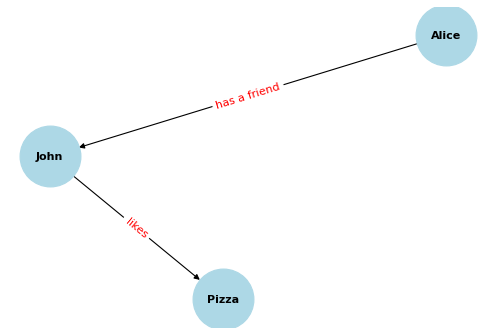

In [31]:
import networkx as nx
import matplotlib.pyplot as plt


# Fetch records
records = recall_vector_store.similarity_search(
    "Alice", k=2, filter=lambda doc: doc.metadata["user_id"] == "3"
)


# Plot graph
plt.figure(figsize=(6, 4), dpi=80)
G = nx.DiGraph()

for record in records:
    G.add_edge(
        record.metadata["subject"],
        record.metadata["object_"],
        label=record.metadata["predicate"],
    )

pos = nx.spring_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=3000,
    node_color="lightblue",
    font_size=10,
    font_weight="bold",
    arrows=True,
)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
plt.show()